In [56]:
from time import time
import cv2
import argparse
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pdb
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import MiniBatchDictionaryLearning
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from sklearn.feature_extraction import image

In [78]:
# image name
path = './Photos/2007060208_cam01.jpg'
path = './Photos/jo.jpg'
im = cv2.imread(path)
print(im.shape[0]*im.shape[1])

#b: longueur du patch
b = 32

#l: nombre total de patchs
l = 1024

im


921600


array([[[ 63,  51, 117],
        [ 60,  50, 120],
        [ 56,  47, 128],
        ...,
        [ 14,   4,  80],
        [ 14,   5,  78],
        [ 14,   5,  78]],

       [[ 54,  44, 114],
        [ 52,  43, 116],
        [ 47,  41, 123],
        ...,
        [ 14,   4,  80],
        [ 14,   5,  78],
        [ 14,   5,  78]],

       [[ 48,  43, 118],
        [ 46,  43, 123],
        [ 42,  40, 130],
        ...,
        [ 14,   4,  80],
        [ 14,   4,  80],
        [ 14,   4,  80]],

       ...,

       [[  7,   7,   7],
        [  6,   6,   6],
        [  6,   6,   6],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  7,   7,   7],
        [  7,   7,   7],
        [  6,   6,   6],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  8,   8,   8],
        [  7,   7,   7],
        [  7,   7,   7],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [79]:
patches = image.extract_patches_2d(im, (b, b), l)
#patches.shape[0]*patches.shape[1]*patches.shape[2]
patches[0]

array([[[ 45,  39, 218],
        [ 45,  37, 214],
        [ 45,  39, 212],
        ...,
        [ 35,  31, 134],
        [ 33,  30, 129],
        [ 34,  30, 126]],

       [[ 45,  39, 218],
        [ 45,  37, 214],
        [ 45,  39, 212],
        ...,
        [ 35,  31, 134],
        [ 33,  30, 129],
        [ 34,  30, 126]],

       [[ 45,  39, 216],
        [ 45,  38, 213],
        [ 44,  38, 209],
        ...,
        [ 35,  31, 134],
        [ 33,  30, 129],
        [ 34,  30, 126]],

       ...,

       [[ 44,  38, 193],
        [ 45,  37, 192],
        [ 44,  36, 190],
        ...,
        [ 41,  35, 116],
        [ 40,  35, 114],
        [ 40,  35, 110]],

       [[ 42,  40, 189],
        [ 43,  39, 188],
        [ 45,  39, 188],
        ...,
        [ 41,  36, 115],
        [ 40,  36, 112],
        [ 40,  36, 108]],

       [[ 42,  41, 187],
        [ 43,  40, 185],
        [ 43,  40, 185],
        ...,
        [ 41,  36, 115],
        [ 40,  36, 111],
        [ 40,  36, 108]]

In [90]:
def plot_patches(patches, fignum=None, low=0, high=0):
    """
    Given a stack of 2D patches indexed by the first dimension, plot the
    patches in subplots. 
    'low' and 'high' are optional arguments to control which patches
    actually get plotted. 'fignum' chooses the figure to plot in.
    """
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in xrange(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            #ax = plt.axis('off')
            im = plt.imshow(patches[idx])
            #cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)

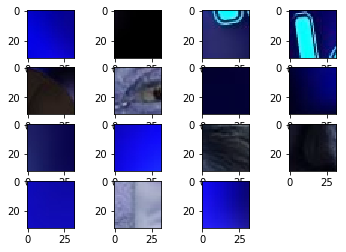

In [91]:
plot_patches(patches[10:25])

In [ ]:
#Projet guez
def noisy_patches(image, dict_learning=False, channel=None):
    image = image / 255.
    if dict_learning:
        #downsample for higher speed
        image = image[::2, ::2] + image[1::2, ::2] + image[::2, 1::2] + image[1::2, 1::2]
        image /= 4.0

    print('Distorting image...')
    distorted = image.copy()

    if channel :
        height, width, channel = image.shape
        distorted += 0.1 * np.random.randn(height, width, channel)
    else:
        height, width = image.shape
        distorted += 0.075 * np.random.randn(height, width)
    print(distorted.shape)

    print('Extracting reference patches...')
    t0 = time()
    patch_size = (7, 7)
    data = extract_patches_2d(distorted, patch_size)
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data -= mean
    data /= std
    print('done in %.2fs.' % (time() - t0))

    return (data, mean, std)

def ksvd(data):
    print('Updating Dictionary')
    t0 = time()
    dico = MiniBatchDictionaryLearning(n_components=n_comp, 
                                        alpha=2, 
                                        n_iter=n_iter,)
                                        #dict_init=D)
    print('done in %.2fs.' % (time() - t0))
    V = dico.fit(data).components_
    return V, dico

channel = None
if len(image.shape) >2:
    channel = image.shape[2]
    

data, _, _ = noisy_patches(image, dict_learning=True, channel=channel)
dict_final, dico = ksvd(data)
n0_data, mean, std= noisy_patches(image,channel=channel)
dico.set_params(transform_algorithm='omp',transform_n_nonzero_coefs = non_zero_coeff )
code = dico.transform(n0_data)
patches = np.dot(code,dict_final)
patches *= std
patches += mean
patches = (patches.reshape(n0_data.shape[0], b, b, channel))
print('Reconstructing...')
reconstruction = reconstruct_from_patches_2d(patches, (image.shape[0], image.shape[1], channel))
reconstruction*=255
difference = image - reconstruction
error = np.sqrt(np.sum(difference ** 2))
print('Difference (norm: %.2f)' %error)
print('Finished reconstruction..')
cv2.imshow('reconstructed', reconstruction.astype('uint8'))
    